# Clustering techniques with genomic data
## Hierarchical clusters and  K-means

this is the companion colab code for my tutorial in medium about Clustering techniques in Python with genomic data, please read the article for better understanding of the code. In the article I discuss about the theory, the hyperparameters, how to efficiently use the techniques. Here I am providing just generic information about the algorithm and the code. 
this is a colab notebook, you can test in colab (all the code has been tested and you do not need to set your machine)

[Medium article](https://medium.com/leukemiaairesearch/clustering-techniques-with-gene-expression-data-4b35a04f87d5)

for other stories check my medium profile:
[Salvatore Raieli](https://salvatore-raieli.medium.com/)

## Dataset preparation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap


In [ ]:
#dataset
data = pd.read_table("/content/gdrive/My Drive/aml/201028_GSE122505_Leukemia_clean.txt", sep = "\t")
#table of the disease
data.disease.value_counts()

AML                                         969
ALL                                         906
Infection                                   113
CLL                                          85
healthy                                      82
Diabetes_Type_I                              74
AMKL                                         63
Diabetes_Type_II                             29
CML                                          22
clinically_isolated_syndrome                 18
MDS                                          10
DS_transient_myeloproliferative_disorder      8
Name: disease, dtype: int64

In [ ]:
#removing some disease type
data["disease"] = np.where(data["disease"] == "Diabetes_Type_I" , "Diabetes", data["disease"])
data["disease"] = np.where(data["disease"] == "Diabetes_Type_II" , "Diabetes", data["disease"])
other = ['CML','clinically_isolated_syndrome', 'MDS', 'DS_transient_myeloproliferative_disorder']
data = data[~data.disease.isin(other)]
target = data["disease"]
df = data.drop("disease", 1)
df = df.drop("GSM", 1)
df = df.drop("FAB", 1)
df.shape

(2321, 14208)

In [ ]:
df = df.drop(df.var()[(df.var() < 0.3)].index, axis=1)
from scipy.stats import zscore
df = df.apply(zscore)
df.shape

(2321, 4311)

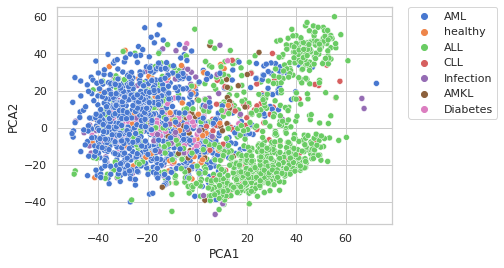

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = pca.fit(df).transform(df)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(target)
y_lan = le.transform(target)

pca_df = pd.DataFrame(columns = ["x", "y", "name", "label"])
pca_df["PCA1"] = X[:, 0]
pca_df["PCA2"] = X[:, 1]
pca_df["Disease"] = target
pca_df["label"] = y_lan

sns.set(style="whitegrid", palette="muted")
#sns.set_theme(style="whitegrid")

ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Disease",  data=pca_df)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("GSE122505_Leukemia_PCA.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_PCA.png")
#pca_df.to_csv("GSE122505_Leukemia_PCA.csv")

## Hierarchical clustering


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(df, 'ward')



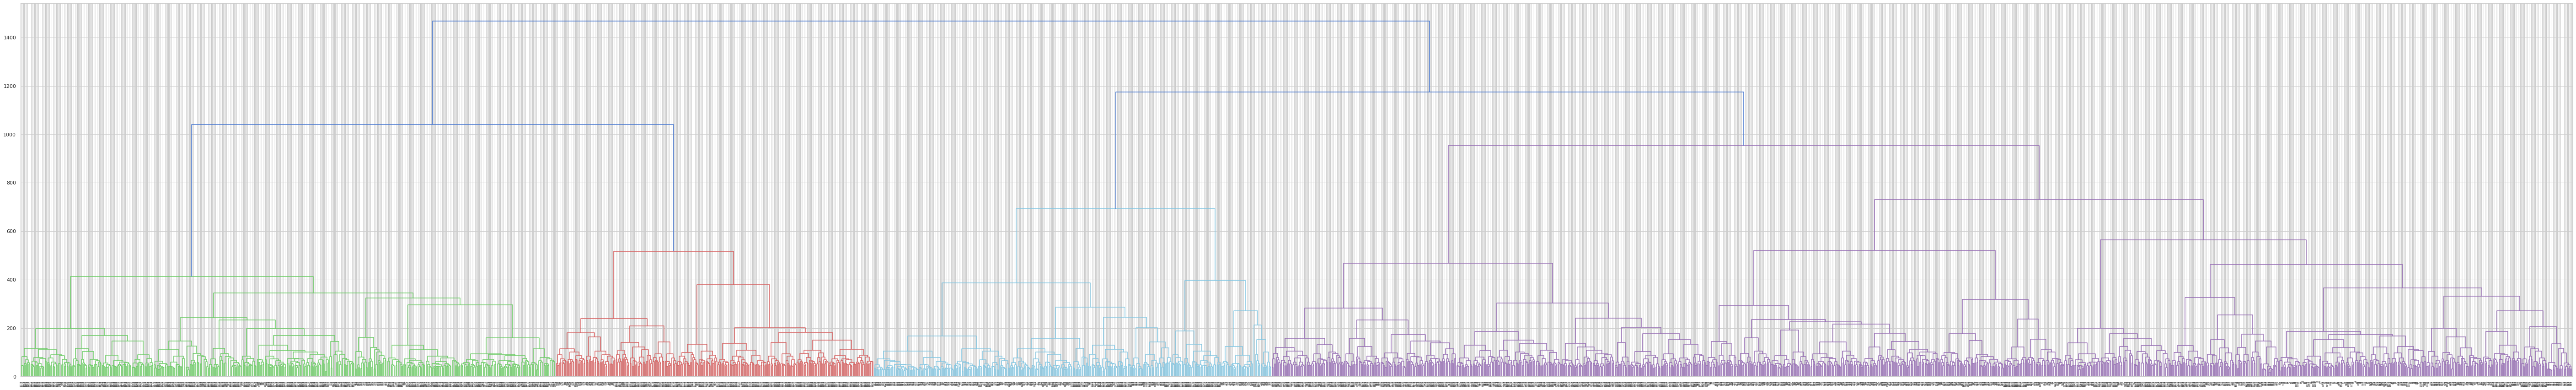

In [ ]:
plt.figure(figsize=(100, 15))
dendrogram(linked,
            orientation='top',
            #labels=target,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
cluster.fit_predict(df)

array([0, 0, 0, ..., 0, 4, 4])

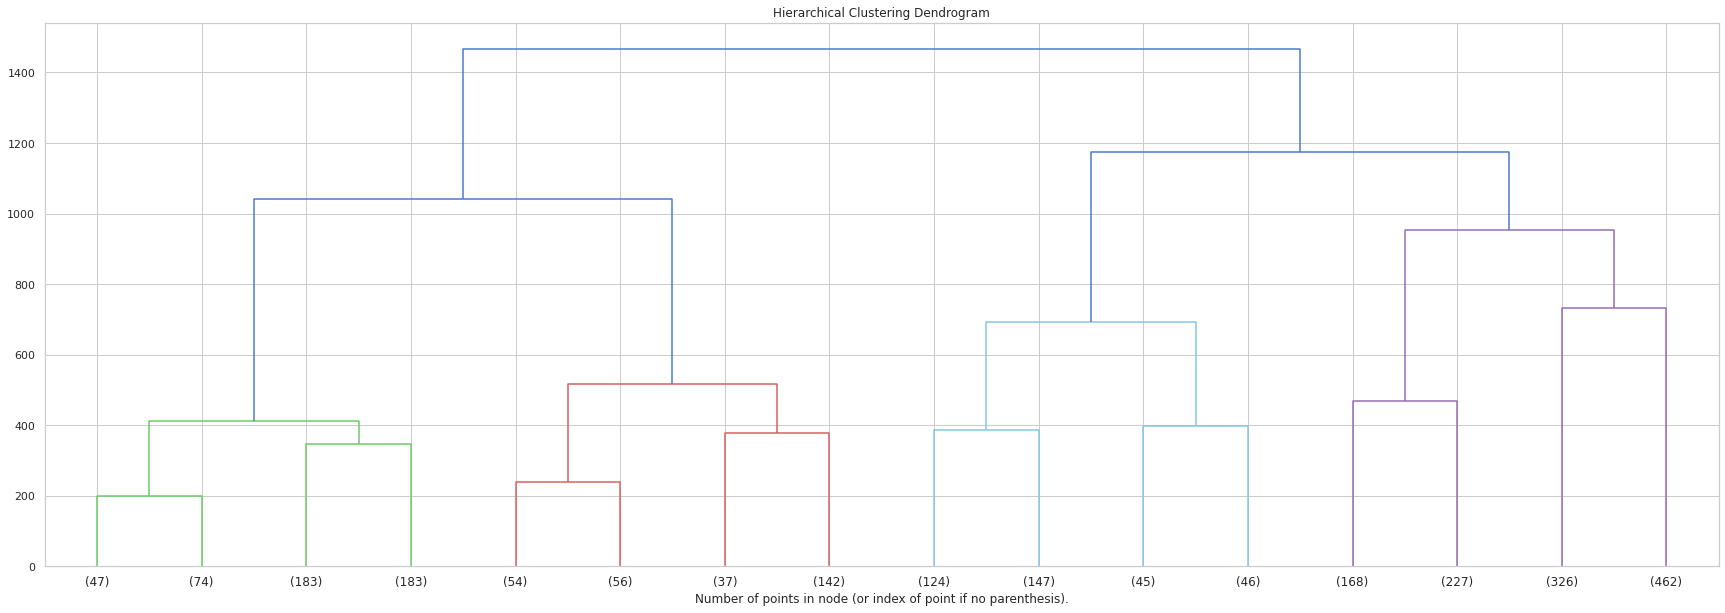

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df)
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


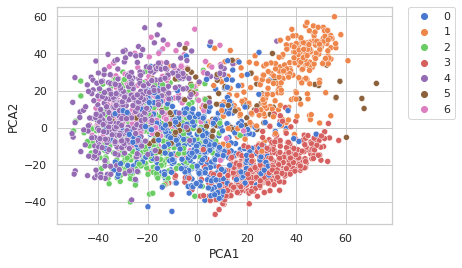

In [ ]:
#plotting on the PCA
pca_df["HC_labels"] = cluster.labels_
pca_df['HC_labels'] = pca_df.HC_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
#sns.set_theme(style="whitegrid")

ax = sns.scatterplot(x="PCA1", y="PCA2", hue="HC_labels",  data=pca_df)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("GSE122505_Leukemia_HC.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_HC.png")
#pca_df.to_csv("GSE122505_Leukemia_HC.csv")

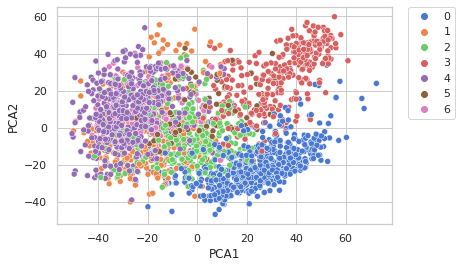

In [ ]:
#compute PCA
pca = PCA(n_components=50)
X = pca.fit(df).transform(df)
#conduct hierarchical clustering
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)
#plot the labels
pca_df["HC_PCA_labels"] = cluster.labels_
pca_df['HC_PCA_labels'] = pca_df.HC_PCA_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="HC_PCA_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#save it
#plt.savefig("GSE122505_Leukemia_HC_PCA.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_HC_PCA.png")
#pca_df.to_csv("GSE122505_Leukemia_HC_PCA.csv")

## K-means clustering

In [ ]:
#install kneed on google colab
!pip install kneed

In [ ]:
#import required libraries
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
kmeans = KMeans(init="random", n_clusters=7, n_init=10, max_iter=300, random_state=42)
kmeans.fit_predict(df)


array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [ ]:
# The lowest SSE value
kmeans.inertia_
# Final locations of the centroid
kmeans.cluster_centers_
# The number of iterations required to converge
kmeans.n_iter_

18

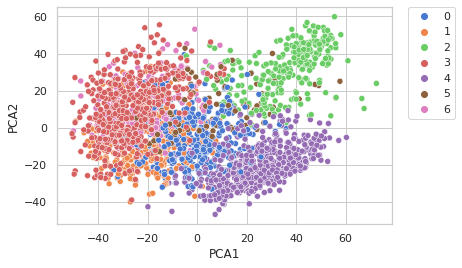

In [ ]:
pca_df["kmeans_labels"] = kmeans.labels_
pca_df['kmeans_labels'] = pca_df.kmeans_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="kmeans_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#save it
#plt.savefig("GSE122505_Leukemia_kmeans.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_kmeans.png")
#pca_df.to_csv("GSE122505_Leukemia_kmeans.csv")

In [ ]:
kmeans_kwargs = { "init": "random",  "n_init": 10, "max_iter": 300, "random_state": 42}
sse = [] #our list
for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(df)
  sse.append(kmeans.inertia_)

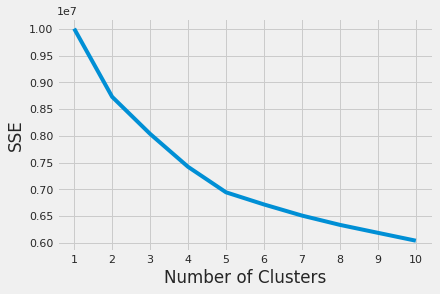

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

5

In [ ]:
# A list containing all the average silhouette coffecient for each K
silhouette_coefficients = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(df)
  score = silhouette_score(df, kmeans.labels_)
  silhouette_coefficients.append(score)

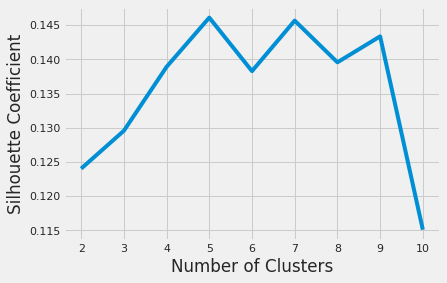

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score
ari_kmeans = adjusted_rand_score(target, pca_df["kmeans_labels"] )
clust_kmeans = adjusted_rand_score(target, cluster.labels_)
ari_kmeans, clust_kmeans

(0.44794417683762133, 0.451477491448074)